# Figures and tables II

This file is part of the replication code for: 

Offshore Profit Shifting and Aggregate Measurement: Balance of Payments, Foreign Investment, Productivity, and the Labor Share by Guvenen, Mataloni Jr., Rassier, and Ruhl. 

This version: February 21, 2022


This file creates figures 10(B) and C4-C6.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_kim_fig():
    # I take so long to write papers, MPL changed their default style.
    plt.style.use('classic')
    
    fig, ax = plt.subplots()
    sns.despine()
    
    ax.tick_params(axis='both', labelsize=14)
    
    ax.grid(linestyle=':')
    
    # mpl will try to set an offset if you are using large nunbers
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    return fig, ax

## Import the value added components by industry

As usual, the dataset is broken into two files from BEA.

In [3]:
comp_o = pd.read_csv('../1-raw-data/va-comp-by-industry-97-16.csv', header=4, nrows=402, na_values=['---'])
comp_o = comp_o.rename(columns={'Unnamed: 1': 'Industry'})
comp_o = comp_o.dropna(subset=['Industry'])
comp_o = comp_o.drop('Line', axis=1)
comp_o.head(1)

,Industry,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,Gross domestic product,8577.6,9062.8,9631.2,10251.0,10581.9,10929.1,11456.5,12217.2,13039.2,...,14474.2,14769.9,14478.1,15049.0,15599.7,16254.0,16843.2,17550.7,18206.0,18695.1


In [4]:
comp_n = pd.read_csv('../1-raw-data/va-comp-by-industry-87-97.csv', header=4, nrows=401, na_values=['...'])
comp_n = comp_n.rename(columns={'Unnamed: 1': 'Industry'})
comp_n = comp_n.dropna(subset=['Industry'])
comp_n = comp_n.drop('Line', axis=1)
comp_n.head(1)

,Industry,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997
0,Gross domestic product,4855.2,5236.4,5641.6,5963.1,6158.1,6520.3,6858.6,7287.2,7639.7,8073.1,8577.6


## Get the needed industries

The industry definitions in the BEA data and our adjustments do not perfectly align. Start by getting the industries from the value added component data. 

In [5]:
def get_ind_comps(indd, df):
    va = df[df['Industry'].str.strip()==indd]
    comp = df.loc[va.index+1]
    temp = va.append(comp)
    temp['Var'] = pd.Series(data={va.index.values[0]:'va', va.index.values[0]+1:'comp'}, name='var')
    temp['Industry'] = indd
    return temp

In [6]:
inds = ['Agriculture, forestry, fishing, and hunting', 'Mining', 'Utilities', 'Construction', 
        'Food and beverage and tobacco products', 'Textile mills and textile product mills',
       'Apparel and leather and allied products', 'Wood products', 'Nonmetallic mineral products', 
       'Paper products', 'Printing and related support activities', 'Petroleum and coal products', 
       'Chemical products', 'Plastics and rubber products', 'Primary metals', 'Fabricated metal products',
       'Machinery', 'Computer and electronic products', 'Electrical equipment, appliances, and components',
       'Motor vehicles, bodies and trailers, and parts', 'Other transportation equipment', 'Furniture and related products',
       'Miscellaneous manufacturing', 'Wholesale trade', 'Retail trade', 'Transportation and warehousing',
       'Information', 'Finance and insurance', 'Real estate and rental and leasing', 'Professional and business services',
       'Management of companies and enterprises', 'Administrative and waste management services',
       'Educational services, health care, and social assistance', 
        'Arts, entertainment, recreation, accommodation, and food services', 
        'Other services, except government'
       ]

df_o = pd.DataFrame()
for i in inds:
    df_o = df_o.append(get_ind_comps(i, comp_o))
    

df_n = pd.DataFrame()
for i in inds:
    df_n = df_n.append(get_ind_comps(i, comp_n))
    
df_n = df_n.drop('1997', axis=1)
comp = pd.merge(left=df_n, right=df_o, how='outer', on=['Var', 'Industry'])
comp = comp.set_index(['Industry', 'Var'])
comp = comp.transpose().sort_index(axis=1)

comp.head(1)

Industry Administrative and waste management services        \
Var                                              comp    va   
1987                                             60.7  87.6   

Industry Agriculture, forestry, fishing, and hunting        \
Var                                             comp    va   
1987                                            15.9  79.3   

Industry Apparel and leather and allied products        \
Var                                         comp    va   
1987                                        17.6  22.8   

Industry Arts, entertainment, recreation, accommodation, and food services  \
Var                                                                   comp   
1987                                                   94.3                  

Industry        Chemical products        ...  \
Var          va              comp    va  ...   
1987      153.4              40.8  91.6  ...   

Industry Textile mills and textile product mills        \
Var                                         comp    va   
1987                                        16.3  21.1   

Industry Transportation and warehousing        Utilities         \
Var                                comp     va      comp     va   
1987                              105.5  153.1      31.1  125.8   

Industry Wholesale trade        Wood products        
Var                 comp     va          comp    va  
1987               154.9  286.2          12.9  19.7  

[1 rows x 70 columns]

## Aggregate to the adjustment level

Now we aggregate to the 19 2-digit NAICS industries we will work with.

In [7]:
def create_aggs(ind_def, df, iname):
    t = df[ind_def].groupby(axis=1,level=1).sum() 
    t = pd.concat({iname:t}, axis=1, names=['Industry'])
    df = pd.merge(left=t, right=df, left_index=True, right_index=True)
    df = df.drop(ind_def, axis=1, level=0)
    return df

In [8]:
aggs = {'Food, textiles, apparel': 
        ['Food and beverage and tobacco products', 
         'Textile mills and textile product mills', 
         'Apparel and leather and allied products'],
       'Wood, paper, printing, petroleum, chemicals, plastics':
        ['Wood products', 
         'Nonmetallic mineral products', 
         'Paper products', 
         'Printing and related support activities', 
         'Petroleum and coal products', 
         'Chemical products', 
         'Plastics and rubber products'],
        'Metals, machinery, computers, electrical equipment, motor vehicles, furniture':
        ['Primary metals', 
         'Fabricated metal products',
         'Machinery', 
         'Computer and electronic products', 
         'Electrical equipment, appliances, and components',
         'Motor vehicles, bodies and trailers, and parts', 
         'Other transportation equipment', 
         'Furniture and related products',
         'Miscellaneous manufacturing']
       }


for k in aggs:
    comp = create_aggs(aggs[k], comp, k)
    
comp.columns = comp.columns.swaplevel()
comp = comp.sort_index(axis=1)
comp.index = comp.index.astype(int)


## The unadjusted shares

In [9]:
unadj_lshares = comp['comp']/comp['va']

## The adjusted shares

These are the industry adjustments produced from the confidential BEA micro data.

In [10]:
adj_ind = pd.read_excel('../0-confidential-data-replication-files/USDIA/OutputAdjNetIndustry.xlsx')
adj_ind = adj_ind.set_index(['Year', 'IEDindPar'])
adj_ind = adj_ind.unstack(fill_value=0)
adj_ind = adj_ind.reindex(range(1982,2017)).interpolate()
adj_ind = adj_ind['adjwt3s']
adj_ind.head(1)

IEDindPar,1100,2100,2200,2300,3110,3130,3150,3210,3220,3230,...,5200,5300,5411,5412,5415,5500,5600,6000,7000,8000
Year,,,,,,,,,,,,,,,,,,,,,
1982,0.011144,-0.987485,-0.162564,-0.121684,-0.161071,-0.035282,0.008206,-0.002748,-0.085826,0.0,...,0.108821,-0.001695,-0.000843,-0.016731,0.0,-0.001214,-0.019245,-0.035096,-0.019686,-0.017469


These are the aggregate data. We need the adjustment factor. 

In [11]:
aggs = pd.read_csv('../3-intermediate-files/aggregate.csv', index_col='year')
aggs.head(1)

,gnpn,gdpn,gvabusn,gvabusr,gdin,cfcn,corpincn,compn,dom_profitn,gva_deflator,...,poil,fdiusstks,usdiastks,usdiainc_havens,usdiainc_nhavens,usdia_havens,usdia_nhavens,total_mne_va,total_mne_dom_va,hrs
year,,,,,,,,,,,,,,,,,,,,,
1982,3380.299,3343.789,2568.636,4649.957,3334.953,272.52,1745.861,1275.114,197.27,0.5524,...,33.635833,124.677,207.752,8.046,16.782,43.917,163.835,NaN,NaN,73.952


In [12]:
adj_ind = adj_ind.mul(aggs['income_adj_factor'], axis=0)
adj_ind = adj_ind.loc[1987:2016]

In [13]:
comp.columns = comp.columns.swaplevel()
comp = comp.sort_index(axis=1)

In [14]:
comp[('Agriculture, forestry, fishing, and hunting', 'va')] = comp[('Agriculture, forestry, fishing, and hunting', 'va')]-adj_ind[1100]
comp[('Mining', 'va')] = comp[('Mining', 'va')]-adj_ind[2100]
comp[('Utilities', 'va')] = comp[('Utilities', 'va')]-adj_ind[2200]
comp[('Construction', 'va')] = comp[('Construction', 'va')]-adj_ind[2300]
comp[('Food, textiles, apparel', 'va')] = comp[('Food, textiles, apparel', 'va')]-(adj_ind[3110]+adj_ind[3130]+adj_ind[3150])
comp[('Wood, paper, printing, petroleum, chemicals, plastics', 'va')] = (comp[('Wood, paper, printing, petroleum, chemicals, plastics', 'va')]
                                                                         -(adj_ind[3210]+adj_ind[3220]+adj_ind[3230]+adj_ind[3240]+adj_ind[3250]+adj_ind[3260]+adj_ind[3270]))
comp[('Metals, machinery, computers, electrical equipment, motor vehicles, furniture', 'va')] = (comp[('Metals, machinery, computers, electrical equipment, motor vehicles, furniture', 'va')]
                                                                         -(adj_ind[3310]+adj_ind[3320]+adj_ind[3330]+adj_ind[3340]+adj_ind[3350]+adj_ind[3361]+adj_ind[3364]+adj_ind[3370]+adj_ind[3390]))
comp[('Wholesale trade', 'va')] = comp[('Wholesale trade', 'va')]-adj_ind[4200]
comp[('Retail trade', 'va')] = comp[('Retail trade', 'va')]-adj_ind[4400]
comp[('Transportation and warehousing', 'va')] = comp[('Transportation and warehousing', 'va')]-adj_ind[4800]
comp[('Information', 'va')] = comp[('Information', 'va')]-(adj_ind[5110]+adj_ind[5120]+adj_ind[5130]+adj_ind[5140])
comp[('Finance and insurance', 'va')] = comp[('Finance and insurance', 'va')]-adj_ind[5200]
comp[('Real estate and rental and leasing', 'va')] = comp[('Real estate and rental and leasing', 'va')]-adj_ind[5300]
comp[('Professional and business services', 'va')] = comp[('Professional and business services', 'va')]-(adj_ind[5411]+adj_ind[5412]+adj_ind[5415])
comp[('Management of companies and enterprises', 'va')] = comp[('Management of companies and enterprises', 'va')]-adj_ind[5500]

comp[('Administrative and waste management services', 'va')] = comp[('Administrative and waste management services', 'va')]-adj_ind[5600]
comp[('Educational services, health care, and social assistance', 'va')] = comp[('Educational services, health care, and social assistance', 'va')]-adj_ind[6000]
comp[('Arts, entertainment, recreation, accommodation, and food services', 'va')] = comp[('Arts, entertainment, recreation, accommodation, and food services', 'va')]-adj_ind[7000]
comp[('Other services, except government', 'va')] = comp[('Other services, except government', 'va')]-adj_ind[8000]


C:\Users\kimru\anaconda3\lib\site-packages\pandas\core\ops\common.py:115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


In [15]:
naics = {'Agriculture, forestry, fishing, and hunting': 11,
        'Mining':21,
        'Utilities':22,
        'Construction':23,
        'Food, textiles, apparel':31,
        'Wood, paper, printing, petroleum, chemicals, plastics':32,
        'Metals, machinery, computers, electrical equipment, motor vehicles, furniture':33,
        'Wholesale trade':42,
        'Retail trade':44,
        'Transportation and warehousing':48,
        'Information':51,
        'Finance and insurance':52,
        'Real estate and rental and leasing':53,
        'Professional and business services':54,
        'Management of companies and enterprises':55,
        'Administrative and waste management services':56,
        'Educational services, health care, and social assistance':60,
        'Arts, entertainment, recreation, accommodation, and food services':70,
        'Other services, except government':80
        }

In [16]:
comp.columns = comp.columns.swaplevel()
comp = comp.sort_index(axis=1)
adj_lshares = comp['comp']/comp['va']

## Figure 10(B)

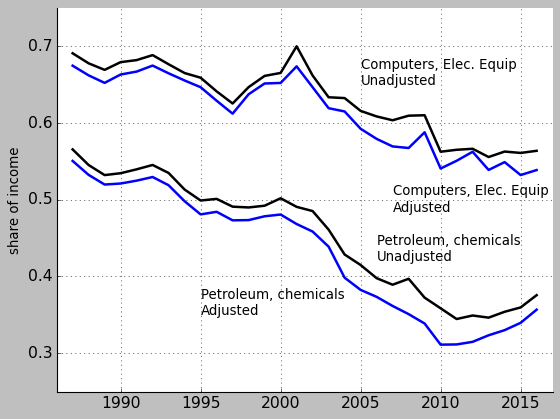

In [17]:
fig, ax = get_kim_fig()
ax.plot(adj_lshares.index, adj_lshares['Metals, machinery, computers, electrical equipment, motor vehicles, furniture'], linewidth=2.25, color='blue')
ax.plot(unadj_lshares.index, unadj_lshares['Metals, machinery, computers, electrical equipment, motor vehicles, furniture'], linewidth=2.25, color='black')

ax.plot(adj_lshares.index, adj_lshares['Wood, paper, printing, petroleum, chemicals, plastics'], linewidth=2.25, color='blue')
ax.plot(unadj_lshares.index, unadj_lshares['Wood, paper, printing, petroleum, chemicals, plastics'], linewidth=2.25, color='black')

ax.text(2005, 0.65, 'Computers, Elec. Equip\nUnadjusted')
ax.text(2007, 0.485, 'Computers, Elec. Equip\nAdjusted')

ax.text(1995, 0.35, 'Petroleum, chemicals\nAdjusted')
ax.text(2006, 0.42, 'Petroleum, chemicals\nUnadjusted')

ax.set_xlim(1986, 2017)
ax.set_ylim(0.25, 0.75)
ax.set_ylabel('share of income')

fig.savefig('../4-figures/two_industries.pdf', bbox_inches='tight')

plt.show()

## Figures C4-C6 

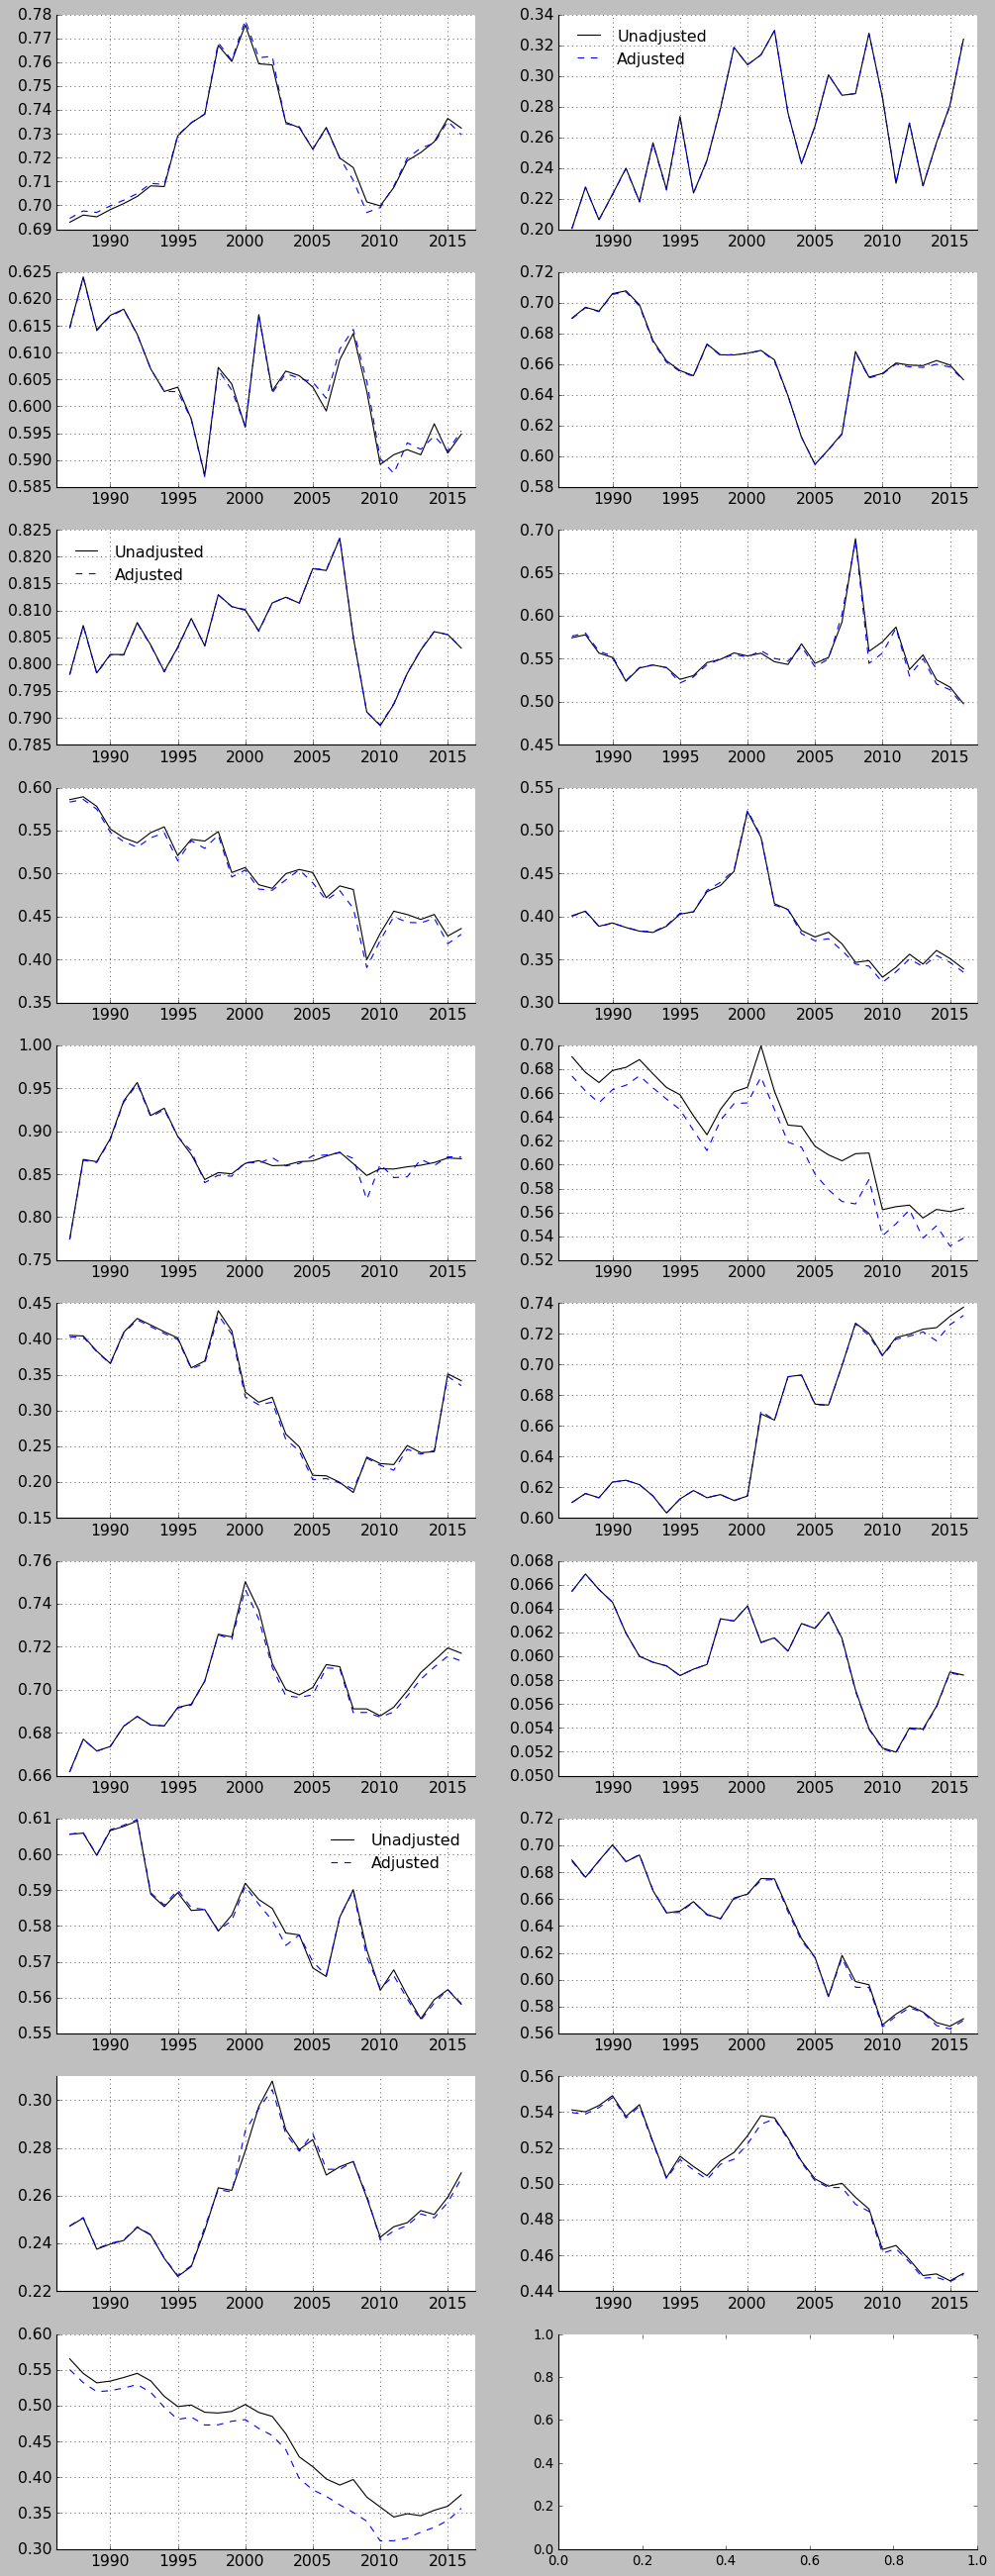

In [18]:
fig, ax = plt.subplots(10, 2, figsize=(15,40))
for c, a in zip(adj_lshares, fig.axes):
    a.plot(unadj_lshares.index, unadj_lshares[c], color='black', label='Unadjusted')
    a.plot(adj_lshares.index, adj_lshares[c], color='blue', linestyle='--', label='Adjusted')
    
    if (c == 'Agriculture, forestry, fishing, and hunting') or (c == 'Educational services, health care, and social assistance'):
        a.legend(frameon=False, loc='upper left')
    elif c == 'Retail trade':    
        a.legend(frameon=False, loc='upper right')
    
    sns.despine()
    a.tick_params(axis='both', labelsize=14)
    a.grid(linestyle=':')
    
    # mpl will try to set an offset if you are using large nunbers
    a.get_xaxis().get_major_formatter().set_useOffset(False)
    
    a.xaxis.set_ticks_position('bottom')
    a.yaxis.set_ticks_position('left')
    a.set_xlim(1986,2017)
    
    extent = a.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('../4-figures/'+str(naics[c])+'ls.pdf', bbox_inches=extent.expanded(1.25, 1.2))
    

## Numbers for the draft

In [19]:
# Section 1: Introduction
x = {}

ind32_diff_share = (
                   (unadj_lshares.loc[2008, 'Wood, paper, printing, petroleum, chemicals, plastics']-unadj_lshares.loc[1987, 'Wood, paper, printing, petroleum, chemicals, plastics'])
                   - (adj_lshares.loc[2008, 'Wood, paper, printing, petroleum, chemicals, plastics']-adj_lshares.loc[1987, 'Wood, paper, printing, petroleum, chemicals, plastics'])
                   )

ind33_diff_share = (
                   (unadj_lshares.loc[2008, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture']-unadj_lshares.loc[1987, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'])
                   - (adj_lshares.loc[2008, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture']-adj_lshares.loc[1987, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'])
                   )

x[1.37] = ['industry 33 adj vs unadj labor share', ind33_diff_share, '{:.1%}']
x[1.38] = ['industry 32 adj vs unadj labor share', ind32_diff_share, '{:.1%}']


# Section 5: 

ind32_avg_diff = unadj_lshares.loc[2000:2016, 'Wood, paper, printing, petroleum, chemicals, plastics'].mean() - adj_lshares.loc[2000:2016, 'Wood, paper, printing, petroleum, chemicals, plastics'].mean()
x[5.41] = ['2000-2016, NAICS 32 avg unadj - avg adj labor share', ind32_avg_diff, '{:.1%}']

ind32_max_diff = unadj_lshares.loc[2010, 'Wood, paper, printing, petroleum, chemicals, plastics'].mean() - adj_lshares.loc[2010, 'Wood, paper, printing, petroleum, chemicals, plastics'].mean()
x[5.42] = ['2000-2016, NAICS 32 max unadj - avg adj labor share', ind32_max_diff, '{:.1%}']

ind33_avg_diff = unadj_lshares.loc[2000:2016, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'].mean() - adj_lshares.loc[2000:2016, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'].mean()
x[5.43] = ['2000-2016, NAICS 33 avg unadj - avg adj labor share', ind33_avg_diff, '{:.1%}']

ind33_max_diff = unadj_lshares.loc[2008, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'].mean() - adj_lshares.loc[2008, 'Metals, machinery, computers, electrical equipment, motor vehicles, furniture'].mean()
x[5.44] = ['2000-2016, NAICS 33 max unadj - avg adj labor share', ind33_max_diff, '{:.1%}']


pd.DataFrame.from_dict(x, columns=['Description', 'Number', 'Format'], orient='index').to_csv('../3-intermediate-files/numbers-in-text-II.csv')
